In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import transformers
from transformers import AutoModel
import sys
import math
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.metrics as perf
from scipy.stats import pearsonr
sys.path.insert(0,'..')

from utils.preprocessing import load_data
from utils.transformer_dataset import ReviewDataset
from utils.training import train_text_model, train_text_meta_model, train_meta_model
from utils.evaluation import get_cls_perf, get_reg_perf, get_predictions
from models.transformer_models import UsefulScoreRegressorTextOnly, UsefulScoreRegressorAllFeat, UsefulScoreRegressorMetaOnly
from models.transformer_models import UsefulScoreRegressorLinearBaseline, DrugLinearRegression

In [2]:
# Load data
train, val = load_data('../data/drugsComTrain_raw.csv')

In [4]:
train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'cleanReview', 'usefulScore', 'ratingNormalized',
       'daysOld', 'ageScore', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
       'Birth Control', 'Depression', 'Insomnia', 'Obesity', 'Pain',
       'Weight Loss'],
      dtype='object')

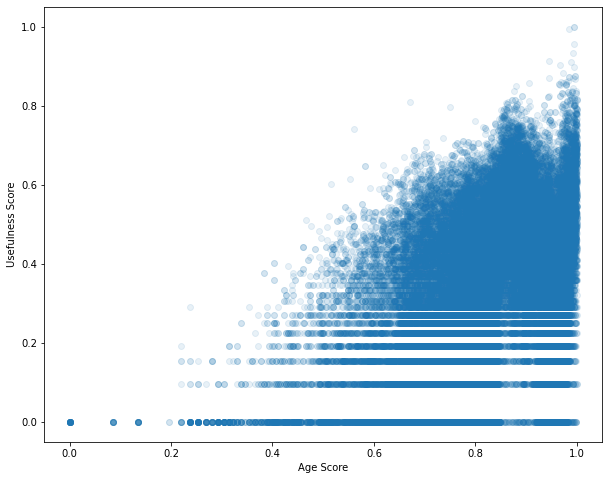

In [16]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulScore, alpha=0.1)
ax.set_ylabel('Usefulness Score')
ax.set_xlabel('Age Score')

plt.show()

The above plot shows all our data with the logged age score and logged usefulness score. The distribution is not as even as the ones discussed below.

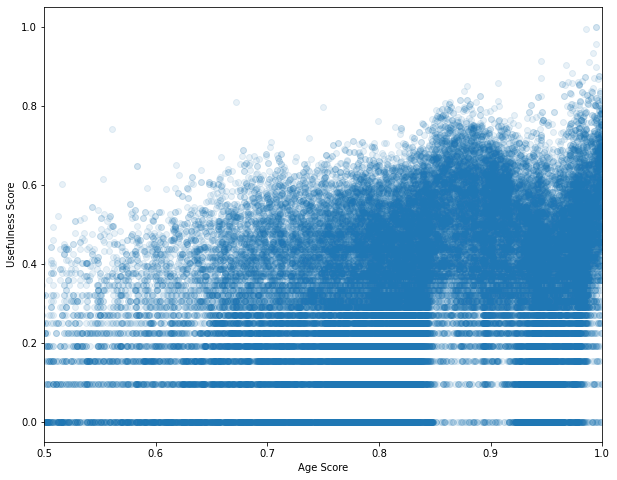

In [18]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulScore, alpha=0.1)
ax.set_ylabel('Usefulness Score')
ax.set_xlabel('Age Score')
ax.set_xlim([0.5, 1])

plt.show()

The above plot shows the distribution of usefulness score by age score for only the older half of the reviews. However, the distribution is still not very even.

Better to train and evaluate the model on older reviews (e.g., 0.5 to 1) because young reviews have not had time for their usefulness to reach its steady-state yet. Even better may be to only consider older reviews and not use the age of the review as a feature. 

In [31]:
train.date.dt.year.value_counts(normalize=True).sort_index()

2008    0.026991
2009    0.066801
2010    0.052359
2011    0.076087
2012    0.064638
2013    0.076592
2014    0.076754
2015    0.173972
2016    0.214413
2017    0.171394
Name: date, dtype: float64

To improve the model training and validation, only consider reviews from 2008 to 2011.

In [2]:
#### Load data with year range from 2008 to 2011
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011])

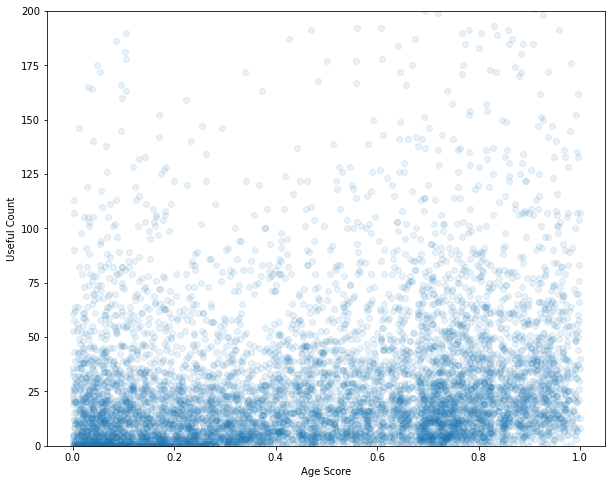

In [3]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCount, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 200])

plt.show()

As shown above, removing usefulness outliers gives a more even distribution of usefulness than taking logs. Our chosen date range will thus be 2009 to 2011

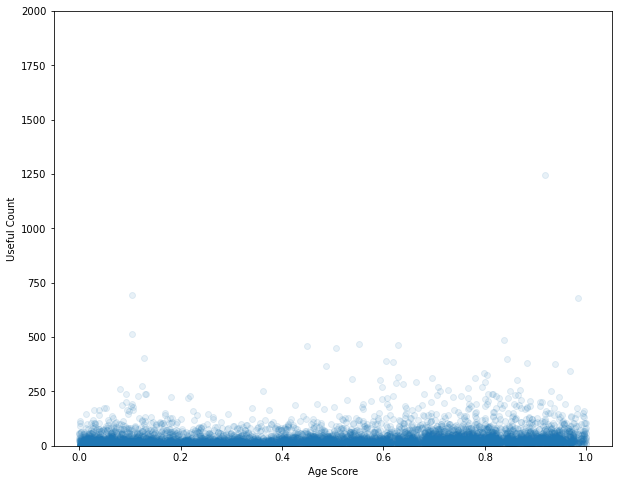

In [4]:
# Create scatter plots between features and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCount, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
#ax.set_xlim([0, 1])
ax.set_ylim([0, 2000])

plt.show()

As shown, most of the mass is between 0 and 250 in terms of the usefulCount, with some outliers above. In order to help the model, we could consider capping these outliers to a maximum usefulCountCapped of 250

Next, we will explore some of the specific reviews at different levels of usefulness. It will be interesting to look at some of the highly useful outlier reviews, to try and see what makes them qualitatively different from other useful reviews that are not outliers.

In [5]:
train.loc[train['usefulCount'] >= 700]

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleanReview,usefulScoreLog,usefulCountCapped,...,ADHD,Acne,Anxiety,Bipolar Disorde,Birth Control,Depression,High Blood Pressure,Insomnia,Pain,ibromyalgia
4249,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,I have had my IUD for over a year now and I th...,1.0,1247,...,0,0,0,0,1,0,0,0,0,0


In [6]:
train.loc[train['usefulCount']==max(train['usefulCount']), 'cleanReview'].item()

"I have had my IUD for over a year now and I think it's the best thing ever. When I first got it put in I only bled for about a week with a little cramping. After that nothing at all. I haven't had a period for about 8months until I finally got one, and its not bad at all. It's light, no cramping, no headache, nothing. I haven't gained weight, my acne is gone, and my moods are fine. I know all women are different, but I just hear all these horror stories and I just wanted to tell my story, which is a good one. Hope it calms some of your fears."

In [7]:
print(train.loc[train['usefulCount'] == 200, 'daysOld'].item())
print(train.loc[train['usefulCount'] == 200, 'rating'].item())
print(train.loc[train['usefulCount'] == 200, 'condition'].item())
print(train.loc[train['usefulCount'] == 200, 'drugName'].item())
print(train.loc[train['usefulCount'] == 200, 'cleanReview'].item())

760.0
4
ADHD
Lisdexamfetamine
My 8 year old son has been on this mediation for 1 year and a half. He started at 20mg now he is taking 40mg. I have noticed that it does not seem to work and after trying for 9 months to get him off and on something else I am going to take him to a different doctor. Given the fact that after 9 months it is still not working another doctor would try something different but his Doctor just keeps upping the dosage. I have also noticed side effects that disturb. It worries me because my son is usually happy go lucky all the time and with this medicine he is VERY EASILY upset, not himself at all. SO PLEASE BE AWARE OF EVERYTHING YOUR CHILD DOES OR ACTS WHILE TAKING THIS MEDICATION.


In [8]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[0])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[0])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[0]

178.0
10
Birth Control
Ethinyl estradiol / norethindrone


"I'm in the middle of my second week with my first pack. No side effects whatsoever. No weight gain, no mood swings, no nothing which I think is amazing. This is my first time being on birth control and I would definitely recommend Loestrin. "

In [9]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[8])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[8])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[8]

258.0
4
Birth Control
Sprintec


"I've been on this for a week and it's caused me to be more moody and nauseous pretty bad the first few days. On the 3 day it subsided momentarily then came back on the 4th day. It's pretty much off and on, not unbearable but makes me have less of an appetite. Get dull cramps daily and was worried about it until I read these other posts. My breasts are also sore and sex drive has decreased a little.  Also been tired before it even hits 9p.m. Makes my work day longer. "

In [10]:
print(train.loc[train['usefulCount'] == 0, 'daysOld'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'rating'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'condition'].iloc[19])
print(train.loc[train['usefulCount'] == 0, 'drugName'].iloc[19])
train.loc[train['usefulCount'] == 0, 'cleanReview'].iloc[19]

124.0
10
Birth Control
Etonogestrel


"I have Implanon for about 5 months, no bleeding, only spotting. I had my period only once. I don't have any mood swings, I am more relaxed, no PMS. Sometimes light headache, but goes away in few minutes. It doesn't cost me any trouble and save on pads (usually used all package heavy ones and half package light ones). So far no problem."

In [11]:
print(train.loc[train['usefulCount'] == 100, 'daysOld'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'rating'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'condition'].iloc[0])
print(train.loc[train['usefulCount'] == 100, 'drugName'].iloc[0])
train.loc[train['usefulCount'] == 100, 'cleanReview'].iloc[0]

740.0
10
ibromyalgia
Topiramate


"It's a wonder drug - my daughter takes it and lost so much weight. Her headache's are gone, she feels like a million bucks."

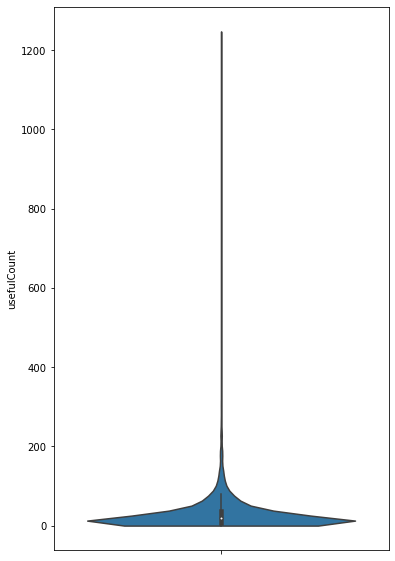

In [12]:
### Work on capping the usefulCount to better handle outliers
fig, ax = plt.subplots(figsize=(6, 10))
sb.violinplot(y=train['usefulCount'], cut=0)
plt.show()

#### Usefulness of reviews by condition

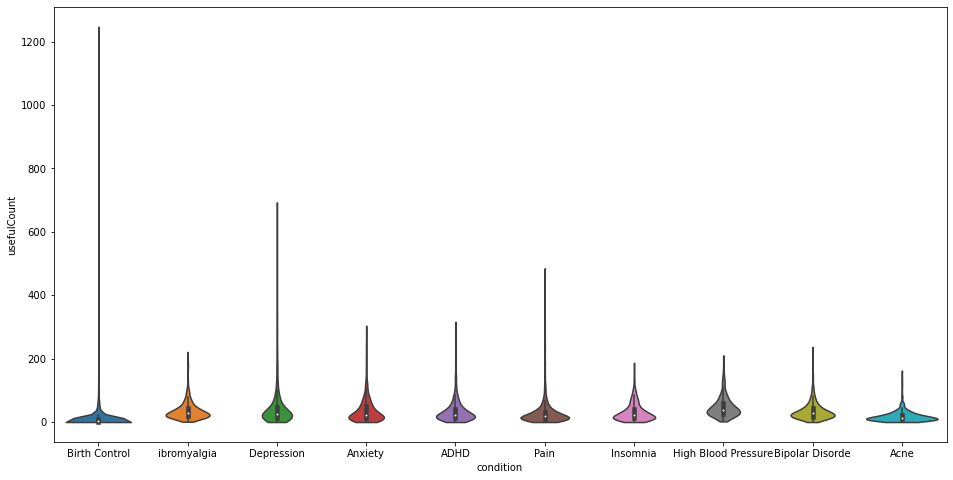

In [13]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011], usefulCount_range=[0, 10000])

fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['condition'], y=train['usefulCount'], cut=0)
plt.show()

#### Usefulness by condition

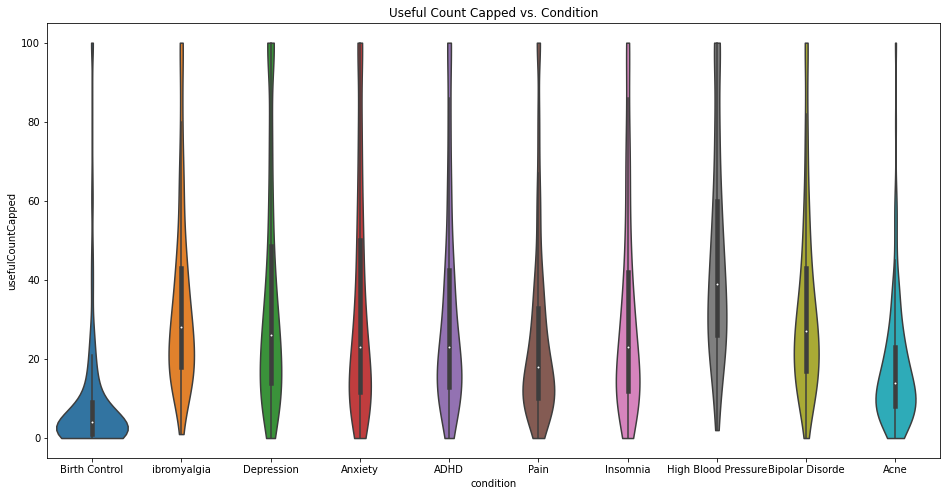

In [21]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2011], usefulCount_range=[0, 100])

fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['condition'], y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped vs. Condition')
plt.show()

Note that the distribution of usefulness scores are somewhat similar across condition, but different for birth control.

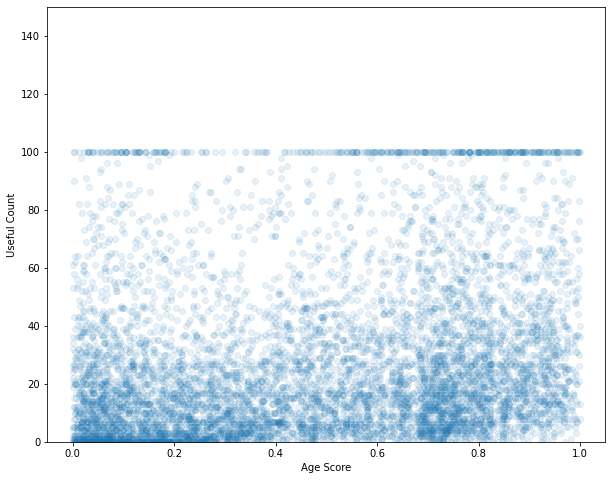

In [15]:
# Create scatter plots between age score and target variable
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCapped, alpha=0.1)
ax.set_ylabel('Useful Count')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 150])

plt.show()

In [16]:
# Check count of reviews by condition
train['condition'].value_counts()

Birth Control          1836
Pain                   1387
Depression             1115
Anxiety                 684
Bipolar Disorde         482
ADHD                    475
Insomnia                469
High Blood Pressure     461
Acne                    409
ibromyalgia             359
Name: condition, dtype: int64

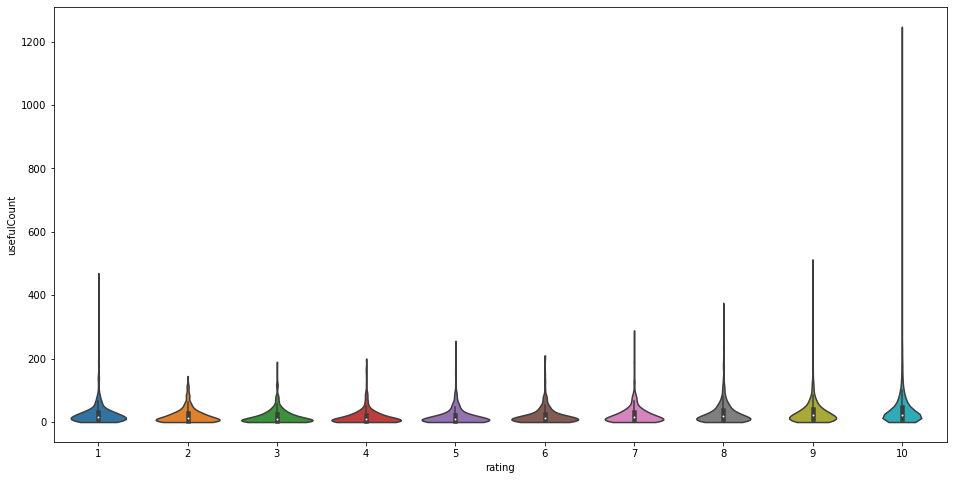

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['rating'], y=train['usefulCount'], cut=0)
plt.show()

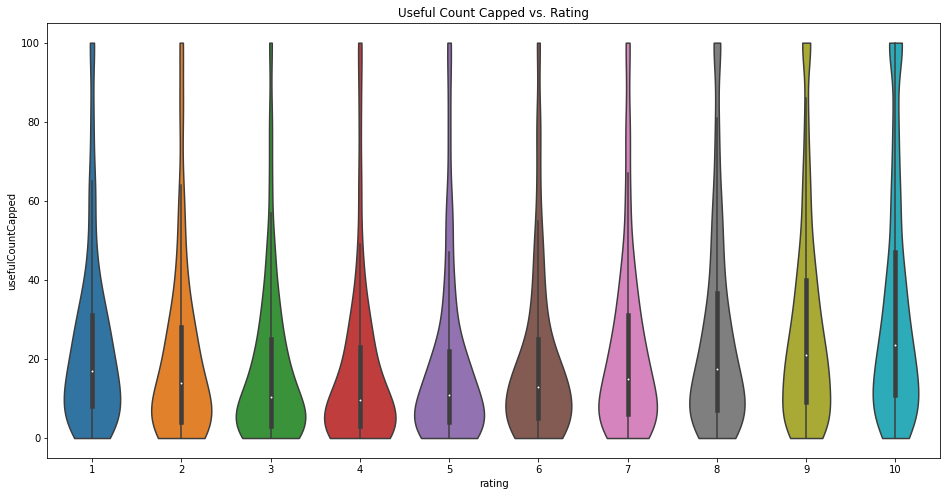

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x=train['rating'], y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped vs. Rating')
plt.show()

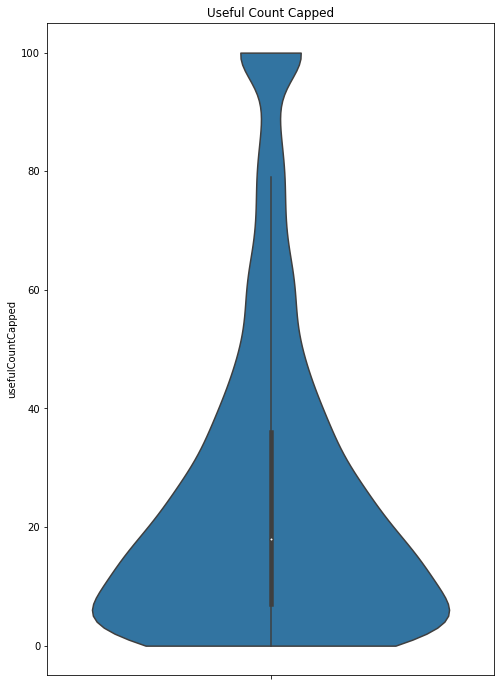

In [19]:
fig, ax = plt.subplots(figsize=(8, 12))
sb.violinplot(y=train['usefulCountCapped'], cut=0)
plt.title('Useful Count Capped')
plt.show()

In [24]:
len(train)

7677

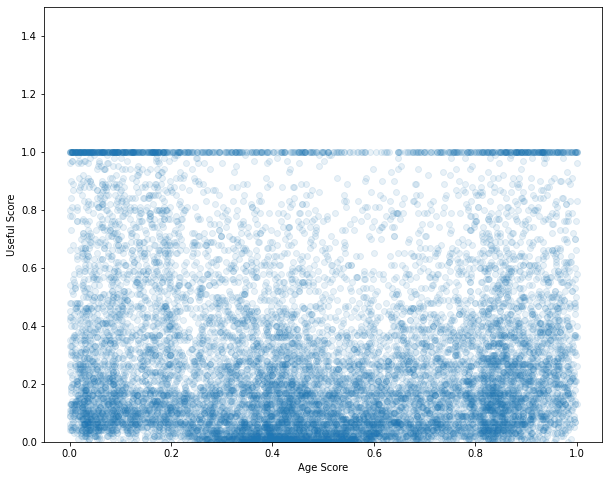

In [3]:
### Try including more years to increase the number of reviews
# Create scatter plots between age score and target variable
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 100])

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCappedNormalized, alpha=0.1)
ax.set_ylabel('Useful Score')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 1.5])

plt.show()

In [4]:
len(train)

12924

#### Train RoBERTa model with updated data

In [11]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('roberta-base', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorTextOnly(encoder)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/RoBERTa_Frozen_TextOnly_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00772, train loss: 0.00928
Epoch 1, val loss: 0.00878, train loss: 0.00830
Epoch 2, val loss: 0.00772 -> 0.00734, train loss: 0.00817
Epoch 3, val loss: 0.00734 -> 0.00726, train loss: 0.00802
Epoch 4, val loss: 0.00754, train loss: 0.00806
Epoch 5, val loss: 0.00739, train loss: 0.00806
Epoch 6, val loss: 0.00726 -> 0.00719, train loss: 0.00799
Epoch 7, val loss: 0.00762, train loss: 0.00797
Epoch 8, val loss: 0.00719 -> 0.00718, train loss: 0.00791
Epoch 9, val loss: 0.00718, train loss: 0.00797


#### Metadata-Only Model

In [12]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorMetaOnly(num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/RoBERTa_MetaOnly_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00747, train loss: 0.00814
Epoch 1, val loss: 0.00747 -> 0.00740, train loss: 0.00752
Epoch 2, val loss: 0.00746, train loss: 0.00746
Epoch 3, val loss: 0.00741, train loss: 0.00742
Epoch 4, val loss: 0.00740 -> 0.00733, train loss: 0.00739
Epoch 5, val loss: 0.00733, train loss: 0.00737
Epoch 6, val loss: 0.00740, train loss: 0.00731
Epoch 7, val loss: 0.00733, train loss: 0.00732
Epoch 8, val loss: 0.00733 -> 0.00729, train loss: 0.00732
Epoch 9, val loss: 0.00731, train loss: 0.00729


#### Combined Text and Metadata Model

In [13]:
##### Create pytorch dataset
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('roberta-base', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorAllFeat(encoder, num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                      train_loader=train_loader, val_loader=val_loader,
                      criterion=criterion, save_path='../models/RoBERTa_Frozen_TextMeta_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00754, train loss: 0.00831
Epoch 1, val loss: 0.00754 -> 0.00719, train loss: 0.00750
Epoch 2, val loss: 0.00719 -> 0.00700, train loss: 0.00736
Epoch 3, val loss: 0.00700 -> 0.00680, train loss: 0.00742
Epoch 4, val loss: 0.00704, train loss: 0.00730
Epoch 5, val loss: 0.00698, train loss: 0.00725
Epoch 6, val loss: 0.00692, train loss: 0.00712
Epoch 7, val loss: 0.00680 -> 0.00670, train loss: 0.00714
Epoch 8, val loss: 0.00670, train loss: 0.00716
Epoch 9, val loss: 0.00670 -> 0.00669, train loss: 0.00717


### Exploring different values for year range and correlation between review age and usefulness

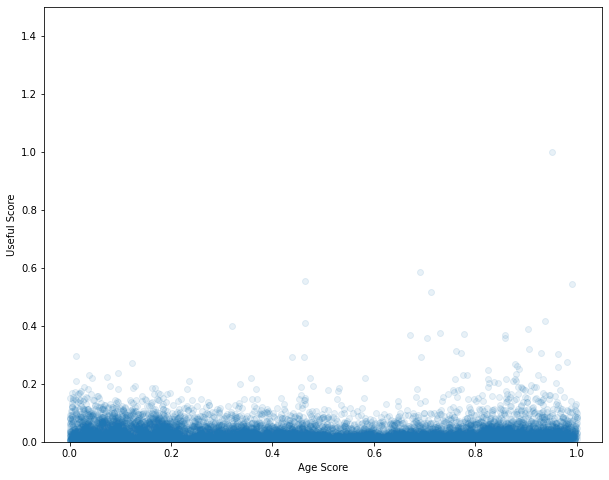

In [22]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 100])

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCappedNormalized, alpha=0.1)
ax.set_ylabel('Useful Score')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 1.5])

plt.show()

In [6]:
# Get usefulCount capped by quantile
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=None,
                      usefulCount_quantile=0.99)

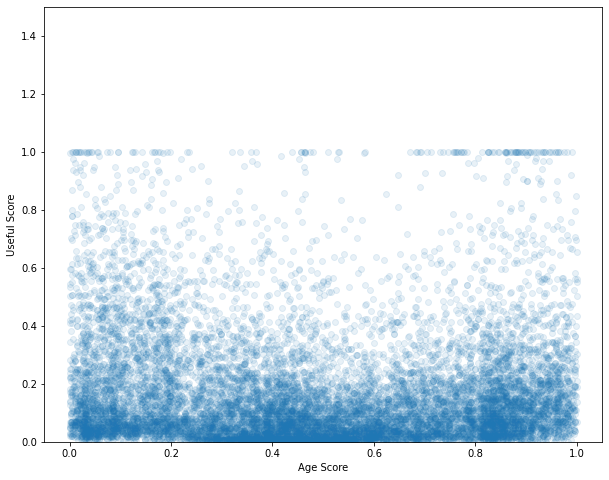

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(train.ageScore, train.usefulCountCappedNormalized, alpha=0.1)
ax.set_ylabel('Useful Score')
ax.set_xlabel('Age Score')
ax.set_ylim([0, 1.5])

plt.show()

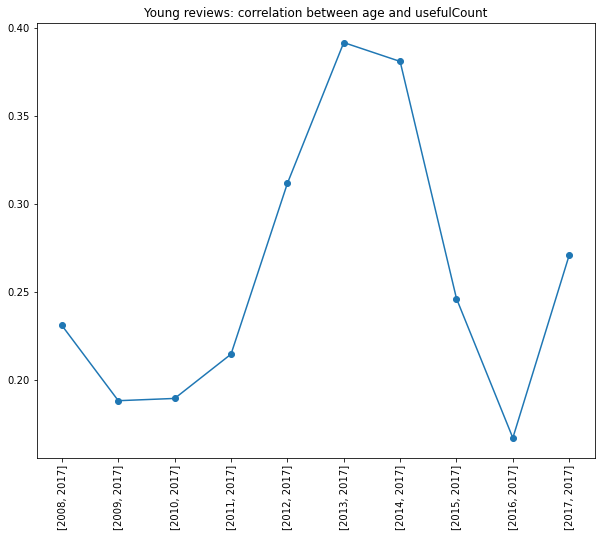

In [34]:
# Get year ranges and useful count caps to try
year_ranges = []
for i in range(2008, 2018):
    if [i, 2017] not in year_ranges:
        year_ranges.append([i, 2017])
# Compute corr across range of year_ranges and count_caps to generate heat-map
corrs = []
for year_range in year_ranges:
    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=year_range, usefulCount_range=None,
                           usefulCount_quantile=0.99)
    corr, _ = pearsonr(train['usefulCount'], train['daysOld'])
    corrs.append([year_range, corr])
# Visualize line plot of how the correlation changes with the year range
fig, ax = plt.subplots(figsize=(10, 8))
corr_df = pd.DataFrame(corrs, columns=['year_range', 'correlation'])
plt.plot(corr_df['year_range'].astype(str), corr_df['correlation'], marker='o')
plt.xticks(rotation=90)
plt.title('Young reviews: correlation between age and usefulCount')
plt.show()

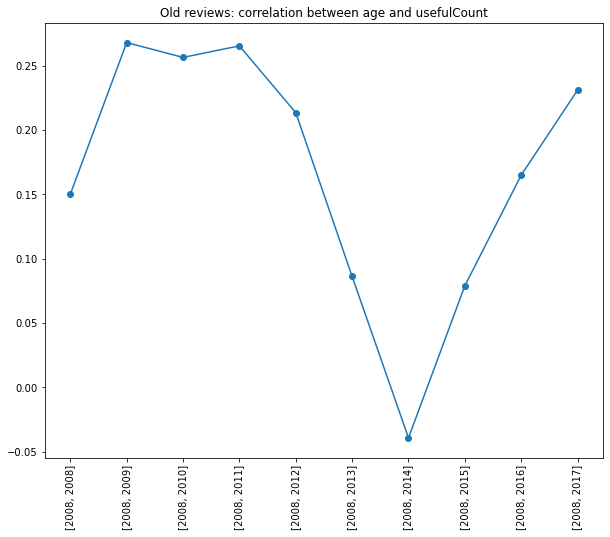

In [35]:
# Get year ranges and useful count caps to try
year_ranges = []
for i in range(2008, 2018):
    if [2008, i] not in year_ranges:
        year_ranges.append([2008, i])
# Compute corr across range of year_ranges and count_caps to generate heat-map
corrs = []
for year_range in year_ranges:
    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=year_range, usefulCount_range=None,
                           usefulCount_quantile=0.99)
    corr, _ = pearsonr(train['usefulCount'], train['daysOld'])
    corrs.append([year_range, corr])
# Visualize line plot of how the correlation changes with the year range
fig, ax = plt.subplots(figsize=(10, 8))
corr_df = pd.DataFrame(corrs, columns=['year_range', 'correlation'])
plt.plot(corr_df['year_range'].astype(str), corr_df['correlation'], marker='o')
plt.xticks(rotation=90)
plt.title('Old reviews: correlation between age and usefulCount')
plt.show()

#### Test Model Performance

In [24]:
train, val = load_data('../data/drugsComTest_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 100],
                      usefulCount_quantile=None)
test = pd.concat((train, val), axis=0)

In [25]:
nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

testset = ReviewDataset(test, 'roberta-base', nonTextCols, targetCol)
test_loader = DataLoader(dataset=testset, batch_size=8, shuffle=False)

In [39]:
results = []
model = torch.load('../models/RoBERTa_Frozen_TextMeta_Clip.pt')
model = model.cuda()
mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='text-meta')
results.append(['text-meta', mae, rmse, r2])

In [40]:
model = torch.load('../models/RoBERTa_Frozen_TextOnly_Clip.pt')
model = model.cuda()
mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='text')
results.append(['text', mae, rmse, r2])

In [41]:
model = torch.load('../models/RoBERTa_MetaOnly_Clip.pt')
model = model.cuda()
mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='meta')
results.append(['meta', mae, rmse, r2])

In [3]:
#### Also test the naive model's performance of always predicting the mean of the training data
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 100],
                      usefulCount_quantile=None)
test = pd.concat((train, val), axis=0)
train_mean = np.mean(train['usefulCountCappedNormalized'])
gt = list(test['usefulCountCappedNormalized'])
pred = [train_mean for x in range(len(gt))]
r2 = perf.r2_score(gt, pred)
rmse = perf.mean_squared_error(gt, pred, squared=False)
results.append(['naive', mae, rmse, r2])

In [43]:
results

[['text-meta', 0.23100565, 0.3471246256006839],
 ['text', 0.240224, 0.2939786546033777],
 ['meta', 0.23914643, 0.30029849207124504],
 ['naive', 0.28591249590860146, -0.00011816975242262551]]

#### Exploring usefulness as a classification problem

In [57]:
for review in list(train.loc[(train['usefulCount']==100) & (train['Birth Control']==0), 'cleanReview']):
    print(review)
    print()

My son has had ADHD for as long as I can remember. We have been through 5 different ADHD medicines with some sort of side affect with each one. I started doing research and finding out what my options were. I found the Vyvanse by accident and I had to find out more. What I read was so amazing I wanted it for my son. I couldn't believe how hard it was to get the Doctors to understand I knew what I was doing and I was going to do whatever it took to get my son the proper help. Well needless to say my son has been on this medicine for quite a few months now and the difference is Amazing. He went from D and F's (not kidding) to an A student in this past report card. To see the smile on his face and the sense of accomplishment was worth it all. 

I have a very stressful life. After my mother passing in 2005, I started having major anxiety. It truly was debilitating my entire life. My Dr put me on 0.05 mg twice a day to help. It was the BEST thing I ever did. I have been on them for 8 yrs no

In [58]:
for review in list(train.loc[(train['usefulCount']==0) & (train['Birth Control']==0), 'cleanReview']):
    print(review)
    print()

Very strong. The best ADHD medication. It's very, very costly but works great. I highly recommend it. I finally feel normal and like Visa, that's truly priceless. I am 22 years old and been on all ADD medicines. Finally found one that's perfect for me. Life is great. Even great for my depression. It's a miracle drug. Thanks for your time.

I was prescribed this medicine yesterday. I had been taking Norco 10-25 which was no longer working. My guess is the tolerance I had built up. I took it yesterday and it really helped my pain. I have severe pack pain due to narrowing of spine due to herniated disc and osteoarthritis which is in most of my major joints. I had one hip replaced 8 months ago and due for another soon. I took my dose this morning, 50mg every 8 hours and really weird feeling. Hoping it goes away because my husband said I was a lot more pleasant to be around yesterday. I was also put on Lyrica at bedtime. Could this be cause of spacey feeling?

I am 16 and I just started tak

#### Train Linear Regression Baseline (NoCap)

In [3]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorLinearBaseline(num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/distilBERT_MetaOnly_LinearBaseline.pt', clip=10000.0)

Epoch 0, val loss: inf -> 0.00011073, train loss: 0.00070402
Epoch 1, val loss: 0.00011073 -> 0.00010974, train loss: 0.00012923
Epoch 2, val loss: 0.00011021, train loss: 0.00013033
Epoch 3, val loss: 0.00010983, train loss: 0.00013053
Epoch 4, val loss: 0.00011153, train loss: 0.00013024
Epoch 5, val loss: 0.00011221, train loss: 0.00012995
Epoch 6, val loss: 0.00011226, train loss: 0.00013007
Epoch 7, val loss: 0.00011224, train loss: 0.00013028
Epoch 8, val loss: 0.00011086, train loss: 0.00013027
Epoch 9, val loss: 0.00011483, train loss: 0.00013004


#### Train Meta-only Neural Network (NoCap)

In [4]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorMetaOnly(num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/distilBERT_MetaOnly_NoClip.pt', clip=10000.0)

Epoch 0, val loss: inf -> 0.00011308, train loss: 0.00016450
Epoch 1, val loss: 0.00011308 -> 0.00010739, train loss: 0.00012898
Epoch 2, val loss: 0.00010755, train loss: 0.00012778
Epoch 3, val loss: 0.00010779, train loss: 0.00012686
Epoch 4, val loss: 0.00010739 -> 0.00010614, train loss: 0.00012643
Epoch 5, val loss: 0.00010763, train loss: 0.00012569
Epoch 6, val loss: 0.00010793, train loss: 0.00012584
Epoch 7, val loss: 0.00011454, train loss: 0.00012579
Epoch 8, val loss: 0.00011066, train loss: 0.00012632
Epoch 9, val loss: 0.00010737, train loss: 0.00012573


#### Train Text-only Neural Netowrk (NoCap)

In [5]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'distilbert-base-uncased', nonTextCols, targetCol)
valset = ReviewDataset(val, 'distilbert-base-uncased', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('distilbert-base-uncased', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorTextOnly(encoder)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/distilBERT_Frozen_TextOnly_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00012702, train loss: 0.00029887
Epoch 1, val loss: 0.00012702 -> 0.00010928, train loss: 0.00013918
Epoch 2, val loss: 0.00011368, train loss: 0.00014007


KeyboardInterrupt: 

#### Train Text + Metadata Neural Network (NoCap)

In [2]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

trainset = ReviewDataset(train, 'distilbert-base-uncased', nonTextCols, targetCol)
valset = ReviewDataset(val, 'distilbert-base-uncased', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('distilbert-base-uncased', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorAllFeat(encoder, num_meta_feats=len(nonTextCols))
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                      train_loader=train_loader, val_loader=val_loader,
                      criterion=criterion, save_path='../models/distilBERT_Frozen_TextMeta_Clip.pt', clip=1.0)

Epoch 0, val loss: inf -> 0.00015832, train loss: 0.00037787
Epoch 1, val loss: 0.00015832 -> 0.00010223, train loss: 0.00013529
Epoch 2, val loss: 0.00010730, train loss: 0.00013279
Epoch 3, val loss: 0.00011082, train loss: 0.00013072
Epoch 4, val loss: 0.00011211, train loss: 0.00013387
Epoch 5, val loss: 0.00018426, train loss: 0.00013479
Epoch 6, val loss: 0.00010235, train loss: 0.00013623
Epoch 7, val loss: 0.00012764, train loss: 0.00013379
Epoch 8, val loss: 0.00012122, train loss: 0.00013179
Epoch 9, val loss: 0.00010223 -> 0.00010140, train loss: 0.00013448


#### Model Evaluation

In [17]:
train, val = load_data('../data/drugsComTest_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                      usefulCount_quantile=None)
test = pd.concat((train, val), axis=0)

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountCappedNormalized'

testset = ReviewDataset(test, 'distilbert-base-uncased', nonTextCols, targetCol)
test_loader = DataLoader(dataset=testset, batch_size=8, shuffle=False)

results = []
model = torch.load('../models/distilBERT_Frozen_TextMeta_Clip.pt')
model = model.cuda()
mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='text-meta')
results.append(['text-meta', mae, rmse, r2])

# model = torch.load('../models/distilBERT_MetaOnly_NoClip.pt')
# model = model.cuda()
# mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='meta')
# results.append(['meta', mae, rmse, r2])

# model = torch.load('../models/distilBERT_MetaOnly_LinearBaseline.pt')
# model = model.cuda()
# mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='meta')
# results.append(['linear-meta', mae, rmse, r2])

print(results)

[['text-meta', 0.05770548, 0.04874883419214704]]


In [ ]:
# Q: why is RMSE lower but also r2 for the no-cap model?
# Because most of the values are very low.

#### Evaluate another linear baseline

In [2]:
train, val = load_data('../data/drugsComTest_raw.csv', year_range=[2008, 2017], usefulCount_range=[0, 10000],
                      usefulCount_quantile=None)
test = pd.concat((train, val), axis=0)

nonTextCols = ['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control', 'Depression',
               'Insomnia', 'Obesity', 'Pain', 'Weight Loss', 'ratingNormalized']
targetCol = 'usefulCountCappedNormalized'

testset = ReviewDataset(test, 'distilbert-base-uncased', nonTextCols, targetCol)
test_loader = DataLoader(dataset=testset, batch_size=8, shuffle=False)

model = DrugLinearRegression()
model.load_state_dict(torch.load('../models/baseline_model_1.pt'))
model = model.cuda()
mae, rmse, r2 = get_reg_perf(model=model, loader=test_loader, model_type='meta')
predictions, gt = get_predictions(model=model, loader=test_loader, model_type='meta', task='REGRESSION')

In [4]:
print(r2)

0.16653393699683916


In [5]:
print(rmse)

0.03757277


#### Treat prediction as classification

#### Logistic Regression Baseline (Meta Only)

In [4]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                       quantiles_for_class=[0.25, 0.5, 0.75])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountClass'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorLinearBaseline(num_meta_feats=len(nonTextCols), outputs=4)  #classification
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/MetaOnly_LogisticBaseline.pt', clip=10000.0,
                 classify=True)

Epoch 0, val loss: inf -> 0.15154524, train loss: 0.15883265
Epoch 1, val loss: 0.15154524 -> 0.14822563, train loss: 0.14967636
Epoch 2, val loss: 0.14822563 -> 0.14738534, train loss: 0.14795287
Epoch 3, val loss: 0.14738534 -> 0.14713253, train loss: 0.14736252
Epoch 4, val loss: 0.14713253 -> 0.14688717, train loss: 0.14713540
Epoch 5, val loss: 0.14688717 -> 0.14673171, train loss: 0.14695859
Epoch 6, val loss: 0.14673171 -> 0.14663926, train loss: 0.14687218
Epoch 7, val loss: 0.14663926 -> 0.14658948, train loss: 0.14677350
Epoch 8, val loss: 0.14658948 -> 0.14653561, train loss: 0.14676237
Epoch 9, val loss: 0.14655774, train loss: 0.14668013


#### Neural Network (Meta Only)

In [5]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                       quantiles_for_class=[0.25, 0.5, 0.75])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountClass'

trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

model = UsefulScoreRegressorMetaOnly(num_meta_feats=len(nonTextCols), outputs=4)  #classification
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                 train_loader=train_loader, val_loader=val_loader,
                 criterion=criterion, save_path='../models/MetaOnly_NeuralClassifierBaseline.pt', clip=10000.0,
                 classify=True)

Epoch 0, val loss: inf -> 0.14752132, train loss: 0.15637959
Epoch 1, val loss: 0.14752132 -> 0.14703234, train loss: 0.14820815
Epoch 2, val loss: 0.14703234 -> 0.14680249, train loss: 0.14811783
Epoch 3, val loss: 0.14680249 -> 0.14665205, train loss: 0.14780153
Epoch 4, val loss: 0.14665205 -> 0.14661118, train loss: 0.14748831
Epoch 5, val loss: 0.14667410, train loss: 0.14756661
Epoch 6, val loss: 0.14661118 -> 0.14650577, train loss: 0.14752425
Epoch 7, val loss: 0.14668729, train loss: 0.14738787
Epoch 8, val loss: 0.14650577 -> 0.14650083, train loss: 0.14713254
Epoch 9, val loss: 0.14650083 -> 0.14642601, train loss: 0.14721391


#### Text + Meta

In [2]:
train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                       quantiles_for_class=[0.25, 0.5, 0.75])

nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
               'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
targetCol = 'usefulCountClass'

trainset = ReviewDataset(train, 'distilbert-base-uncased', nonTextCols, targetCol)
valset = ReviewDataset(val, 'distilbert-base-uncased', nonTextCols, targetCol)
train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

##### Text-only Transformer Model
encoder = AutoModel.from_pretrained('distilbert-base-uncased', return_dict=True)

# Freeze encoder parameters to avoid CUDA out of memory.
for param in encoder.parameters():
    param.requires_grad = False

model = UsefulScoreRegressorAllFeat(encoder, num_meta_feats=len(nonTextCols), outputs=4)  # classification
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_text_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                      train_loader=train_loader, val_loader=val_loader,
                      criterion=criterion, save_path='../models/distilBERT_Frozen_TextMeta_Clip_Classify4.pt', clip=1.0,
                      classify=True)

Epoch 0, val loss: inf -> 0.15064339, train loss: 0.15510085
Epoch 1, val loss: 0.15064339 -> 0.14586114, train loss: 0.14874184
Epoch 2, val loss: 0.14586114 -> 0.14430881, train loss: 0.14740150
Epoch 3, val loss: 0.15872852, train loss: 0.14613020
Epoch 4, val loss: 0.14430881 -> 0.14282373, train loss: 0.14600028
Epoch 5, val loss: 0.14713136, train loss: 0.14502194
Epoch 6, val loss: 0.14837282, train loss: 0.14486468
Epoch 7, val loss: 0.14500243, train loss: 0.14436947
Epoch 8, val loss: 0.14307444, train loss: 0.14408457
Epoch 9, val loss: 0.14282373 -> 0.14264880, train loss: 0.14336987


#### Look at how model performance changes with number of quantiles

#### Logistic Regression

In [3]:
for num_vals in range(2, 10):
    curr_quantiles = np.array([(1/num_vals)*i for i in range(1, num_vals)])
    print(f'num_vals: {num_vals}')
    print(f'curr_quantiles: {curr_quantiles}')

    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                           quantiles_for_class=curr_quantiles)

    nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
                   'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
    targetCol = 'usefulCountClass'

    trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
    valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
    train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
    val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

    model = UsefulScoreRegressorLinearBaseline(num_meta_feats=len(nonTextCols), outputs=num_vals)  #classification
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                     train_loader=train_loader, val_loader=val_loader,
                     criterion=criterion, save_path=f'../models/Classifiers/MetaOnly_LogisticBaseline{num_vals}.pt', clip=10000.0,
                     classify=True)
    
    #### Load the best model for the training run and evaluate its performance
    model = torch.load(f'../models/Classifiers/MetaOnly_LogisticBaseline{num_vals}.pt')
    f1, acc = get_cls_perf(model=model, loader=val_loader, model_type='META')
    print(f'f1: {f1}, acc: {acc}')
    
    
    print()

num_vals: 2
curr_quantiles: [0.5]
Epoch 0, val loss: inf -> 0.07015962, train loss: 0.07669231
Epoch 1, val loss: 0.07015962 -> 0.06855801, train loss: 0.06859636
Epoch 2, val loss: 0.06855801 -> 0.06834718, train loss: 0.06788633
Epoch 3, val loss: 0.06834718 -> 0.06834717, train loss: 0.06776817
Epoch 4, val loss: 0.06834717 -> 0.06830796, train loss: 0.06772272
Epoch 5, val loss: 0.06830796 -> 0.06829281, train loss: 0.06765937
Epoch 6, val loss: 0.06829281 -> 0.06828241, train loss: 0.06767416
Epoch 7, val loss: 0.06828241 -> 0.06827751, train loss: 0.06768787
Epoch 8, val loss: 0.06830775, train loss: 0.06767823
Epoch 9, val loss: 0.06828139, train loss: 0.06766168
f1: 0.7224751710339539, acc: 0.7267873723305478

num_vals: 3
curr_quantiles: [0.33333333 0.66666667]
Epoch 0, val loss: inf -> 0.11723357, train loss: 0.12316683
Epoch 1, val loss: 0.11723357 -> 0.11505683, train loss: 0.11524252
Epoch 2, val loss: 0.11505683 -> 0.11457484, train loss: 0.11403551
Epoch 3, val loss: 0.11

KeyboardInterrupt: 

#### Neural Metadata

In [ ]:
for num_vals in range(2, 5):
    curr_quantiles = np.array([(1/num_vals)*i for i in range(1, num_vals)])
    print(f'num_vals: {num_vals}')
    print(f'curr_quantiles: {curr_quantiles}')

    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                           quantiles_for_class=curr_quantiles)

    nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
                   'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
    targetCol = 'usefulCountClass'

    trainset = ReviewDataset(train, 'roberta-base', nonTextCols, targetCol)
    valset = ReviewDataset(val, 'roberta-base', nonTextCols, targetCol)
    train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
    val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

    model = UsefulScoreRegressorMetaOnly(num_meta_feats=len(nonTextCols), outputs=num_vals)  #classification
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                     train_loader=train_loader, val_loader=val_loader,
                     criterion=criterion, save_path=f'../models/Classifiers/MetaOnly_NNClassifierBaseline{num_vals}.pt', clip=10000.0,
                     classify=True)
    
    #### Load the best model for the training run and evaluate its performance
    model = torch.load(f'../models/Classifiers/MetaOnly_NNClassifierBaseline{num_vals}.pt')
    f1, acc = get_cls_perf(model=model, loader=val_loader, model_type='META')
    print(f'f1: {f1}, acc: {acc}')
    
    print()

#### Text Only

In [ ]:
for num_vals in range(2, 5):
    curr_quantiles = np.array([(1/num_vals)*i for i in range(1, num_vals)])
    print(f'num_vals: {num_vals}')
    print(f'curr_quantiles: {curr_quantiles}')

    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                           quantiles_for_class=curr_quantiles)

    nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
                   'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
    targetCol = 'usefulCountClass'

    trainset = ReviewDataset(train, 'distilbert-base-uncased', nonTextCols, targetCol)
    valset = ReviewDataset(val, 'distilbert-base-uncased', nonTextCols, targetCol)
    train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
    val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

    ##### Text-only Transformer Model
    encoder = AutoModel.from_pretrained('distilbert-base-uncased', return_dict=True)

    # Freeze encoder parameters to avoid CUDA out of memory.
    for param in encoder.parameters():
        param.requires_grad = False

    model = UsefulScoreRegressorTextOnly(encoder, num_meta_feats=len(nonTextCols), outputs=num_vals)  # classification
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_text_model(num_epochs=10, model=model, optimizer=optimizer,
                     train_loader=train_loader, val_loader=val_loader,
                     criterion=criterion,
                     save_path=f'../models/Classifiers/distilBERT_Frozen_TextOnly_Classify{num_vals}.pt',
                     clip=1.0,
                     classify=True)
    
    #### Load the best model for the training run and evaluate its performance
    model = torch.load(f'../models/Classifiers/distilBERT_Frozen_TextOnly_Classify{num_vals}.pt')
    f1, acc = get_cls_perf(model=model, loader=val_loader, model_type='TEXT')
    print(f'f1: {f1}, acc: {acc}')
    
    print()

#### Text + Meta

In [ ]:
for num_vals in range(2, 5):
    curr_quantiles = np.array([(1/num_vals)*i for i in range(1, num_vals)])
    print(f'num_vals: {num_vals}')
    print(f'curr_quantiles: {curr_quantiles}')

    train, val = load_data('../data/drugsComTrain_raw.csv', year_range=[2009, 2013], usefulCount_range=[0, 10000],
                           quantiles_for_class=curr_quantiles)

    nonTextCols = ['ratingNormalized', 'ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde',
                   'Birth Control', 'Depression', 'High Blood Pressure', 'Insomnia', 'Pain', 'ibromyalgia']
    targetCol = 'usefulCountClass'

    trainset = ReviewDataset(train, 'distilbert-base-uncased', nonTextCols, targetCol)
    valset = ReviewDataset(val, 'distilbert-base-uncased', nonTextCols, targetCol)
    train_loader = DataLoader(dataset=trainset, batch_size=8, shuffle=True)
    val_loader = DataLoader(dataset=valset, batch_size=8, shuffle=False)

    encoder = AutoModel.from_pretrained('distilbert-base-uncased', return_dict=True)

    # Freeze encoder parameters to avoid CUDA out of memory.
    for param in encoder.parameters():
        param.requires_grad = False

    model = UsefulScoreRegressorAllFeat(encoder, num_meta_feats=len(nonTextCols), outputs=num_vals)  # classification
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_text_meta_model(num_epochs=10, model=model, optimizer=optimizer,
                          train_loader=train_loader, val_loader=val_loader,
                          criterion=criterion,
                          save_path=f'../models/Classifiers/distilBERT_Frozen_TextMeta_Classify{num_vals}.pt',
                          clip=1.0,
                          classify=True)
    
    #### Load the best model for the training run and evaluate its performance
    model = torch.load(f'../models/Classifiers/distilBERT_Frozen_TextMeta_Classify{num_vals}.pt')
    f1, acc = get_cls_perf(model=model, loader=val_loader, model_type='TEXT-META')
    print(f'f1: {f1}, acc: {acc}')
    
    print()